[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fonnesbeck/vi_pydata_virginia_2025/blob/master/notebooks/Pathfinder.ipynb)

# Pathfinder Variational Inference

Pathfinder offers an elegant solution to many of the common challenges encountered in traditional variational inference. Rather than directly optimizing a variational distribution to match the posterior, Pathfinder constructs a geometric path through the probability space that connects a simple initial distribution to the target posterior. It offers several advantages:

1. **Speed**: Requires far fewer gradient evaluations than ADVI or MCMC warmup
2. **Scalability**: Performs well on larger problems and high-dimensional models
3. **Parallelization**: Can compute ELBO estimates in parallel, unlike ADVI

On large problems, it should scale better than most MCMC algorithms, including gradient-based methods like NUTS, and requires 1-2 orders of magnitude fewer log density and gradient evaluations than ADVI and the MCMC warmup phase. Moreover, Pathfinder can perform the Monte Carlo KL divergence estimates used to compute ELBO in parallel, providing a major advantage over ADVI, which must evaluate the ELBO sequentially.

Like ADVI, the computational efficiencies may come at the cost of a more biased estimate of the posterior but can be managed through the algorithm's settings. 

In this tutorial, we'll look at how Pathfinder works conceptually, how to use it in PyMC, and examine its performance across several example problems.

## How Pathfinder Works

At a high level, Pathfinder works like this:

1. **Optimization Path**: Uses L-BFGS optimization to find a good path through the parameter space
2. **Local Approximations**: Creates normal (Gaussian) approximations at different points along this path
3. **Sample From Approximations**: Monte Carlo samples are drawn from these approximations
4. **ELBO Evaluation**: Selects the best approximation using the Evidence Lower Bound (ELBO)
5. **Final Sampling**: Draws samples from the best approximation for inference

The name "Pathfinder" comes from the fact that it finds a good path through parameter space to locate a high-quality approximation.

### The Optimization Path

Pathfinder starts by using a mathematical optimization technique called L-BFGS (Limited-memory Broyden-Fletcher-Goldfarb-Shanno) to move through the parameter space. 

Think of this like a hiker trying to climb to the top of a mountain by always moving uphill. L-BFGS efficiently tracks the path upward, using information about how steep the slope is (gradients) and how the terrain changes (approximate Hessian matrix).

Starting from a random point at $\theta^{(0)}$, which should be at the tail-region of the posterior distribution, L-BFGS moves through the body of the distribution and towards a local maximum.

As the optimization proceeds, Pathfinder records both the positions (parameters) and the local landscape information (gradients) at each step along the path.

### Creating Local Approximations

At each point along this optimization path, Pathfinder creates a normal (Gaussian) approximation to the posterior distribution. This is based on a second-order Taylor expansion:

$$ \log p(\theta | x) \approx \log p(\theta_0 | x) + g^T(\theta - \theta_0) + \frac{1}{2}(\theta - \theta_0)^T H (\theta - \theta_0) $$

These approximations have:

- A **mean** representing the central estimate of the parameters
- A **covariance matrix** capturing the uncertainty and relationships between parameters

$$
\begin{align*}
\mu^{(l)} &= \theta^{(l)} - \text{H}^{-1}(\theta^{(l)}) \cdot g^{(l)} \\
\Sigma^{(l)} &= \text{H}^{-1}(\theta^{(l)})
\end{align*}
$$

where $\text{H}(\theta^{(l)}) = - \nabla^2 \log f(\theta^{(l)})$ is the approximate Hessian matrix of the log unnormalized density at $\theta^{(l)}$.

Unlike ADVI, where the covariance matrix is either diagonal (mean-field ADVI) or full rank (full-rank ADVI), Pathfinder uses a low-rank plus diagonal factorization of the inverse Hessian factor, where the rank of the estimate for the covariance matrix can be controlled by the user.

The covariance matrix is constructed efficiently using information from the optimization path, capturing local curvature of the posterior distribution.

### Sampling from Approximations

After constructing the inverse Hessian factors along the optimization path, Pathfinder needs to first sample from the resulting normal approximations and then evaluate the log density of these samples. This is necessary to compute the evidence lower bound (ELBO) in the next step, which will allow us to select the best normal approximation.

The **BFGS-Sample** algorithm generates samples from a local normal approximation to the target distribution. It takes optimization trajectory points and their gradients, along with inverse Hessian factors, and produces $K$ samples from the corresponding multivariate normal distribution. The algorithm handles two cases: 

1. when the rank is greater than or equal to the parameter dimension, it uses a direct Cholesky decomposition approach
2. otherwise, it employs a more computationally-efficient thin QR factorization method. 
    
In both cases, the algorithm transforms standard normal random variables using the covariance structure encoded in the inverse Hessian factors to produce properly distributed samples, while also computing their log density values for subsequent ELBO calculations.

![](images/pathfinder.png)

### Selecting the Best Approximation

Once Pathfinder has created these local normal approximations, it needs to decide which one is best. It does this by computing the **Evidence Lower Bound (ELBO)** for each approximation.

The ELBO measures how well each approximation matches the true posterior. The higher the ELBO, the better the approximation. This calculation involves:

1. Drawing Monte Carlo samples from each normal approximation (from above)
2. Evaluating the log density of these samples under both the target distribution and the approximation
3. Computing the average difference

The approximation with the highest ELBO is selected as the best one.

### Final Sampling

Once the best approximation is selected, Pathfinder draws samples from this approximation, re-using the BFGS-Sample function for this. Then, importance sampling is applied to correct for approximation bias.

These samples can then be used for posterior inference, just like samples from MCMC methods, but typically at a fraction of the computational cost.

### Importance Sampling

Like all VI methods, Pathfinder is approximating the posterior $p(\theta|y)$ using a tractable probability density $q(\theta)$ that is some approximation of $p$. 

$$E[h(\theta) | y] = \frac{\int h(\theta) \frac{p(\theta|y)}{q(\theta)} q(\theta) d\theta}{\int \frac{p(\theta|y)}{q(\theta)} q(\theta) d\theta}$$

Expressed this way, $w(\theta) = p(\theta|y) / q(\theta)$ can be regarded as *weights* for the $M$ values of $\theta$ sampled from $q$ that we can use to correct the sample so that it approximates $h(\theta)$. Specifically, the **importance sampling estimate** of $E[h(\theta) | y]$ is:

$$\hat{h}_{is} = \frac{\sum_{i=1}^{M} h(\theta^{(i)})w(\theta^{(i)})}{\sum_{i=1}^{M} w(\theta^{(i)})}$$

where $\theta^{(i)}$ is the $i^{th}$ sample simulated from $q(\theta)$. The standard error for the importance sampling estimate is:

$$\text{SE}_{is} = \frac{\sqrt{\sum_{i=1}^{M} [(h(\theta^{(i)}) - \hat{h}_{is}) w(\theta^{(i)})]^2}}{\sum_{i=1}^{M} w(\theta^{(i)})}$$

The efficiency of importance sampling is related to the selection of the importance sampling distribution $q$.

### Example: Gamma distribution

As a simple illustration of importance sampling, let's consider the problem of estimating a *gamma distribution* using a normal distribution via importance sampling.

The goal will be to estimate $E[X]$ where $X \sim Gamma(3, 2)$



In [1]:
shape_true, scale_true = 3.0, 2.0
target_mean = shape_true * scale_true

We'll center the normal proposal near the true mean with appropriate variance:

In [2]:
mu_proposal, sigma_proposal = 6.0, 3.0

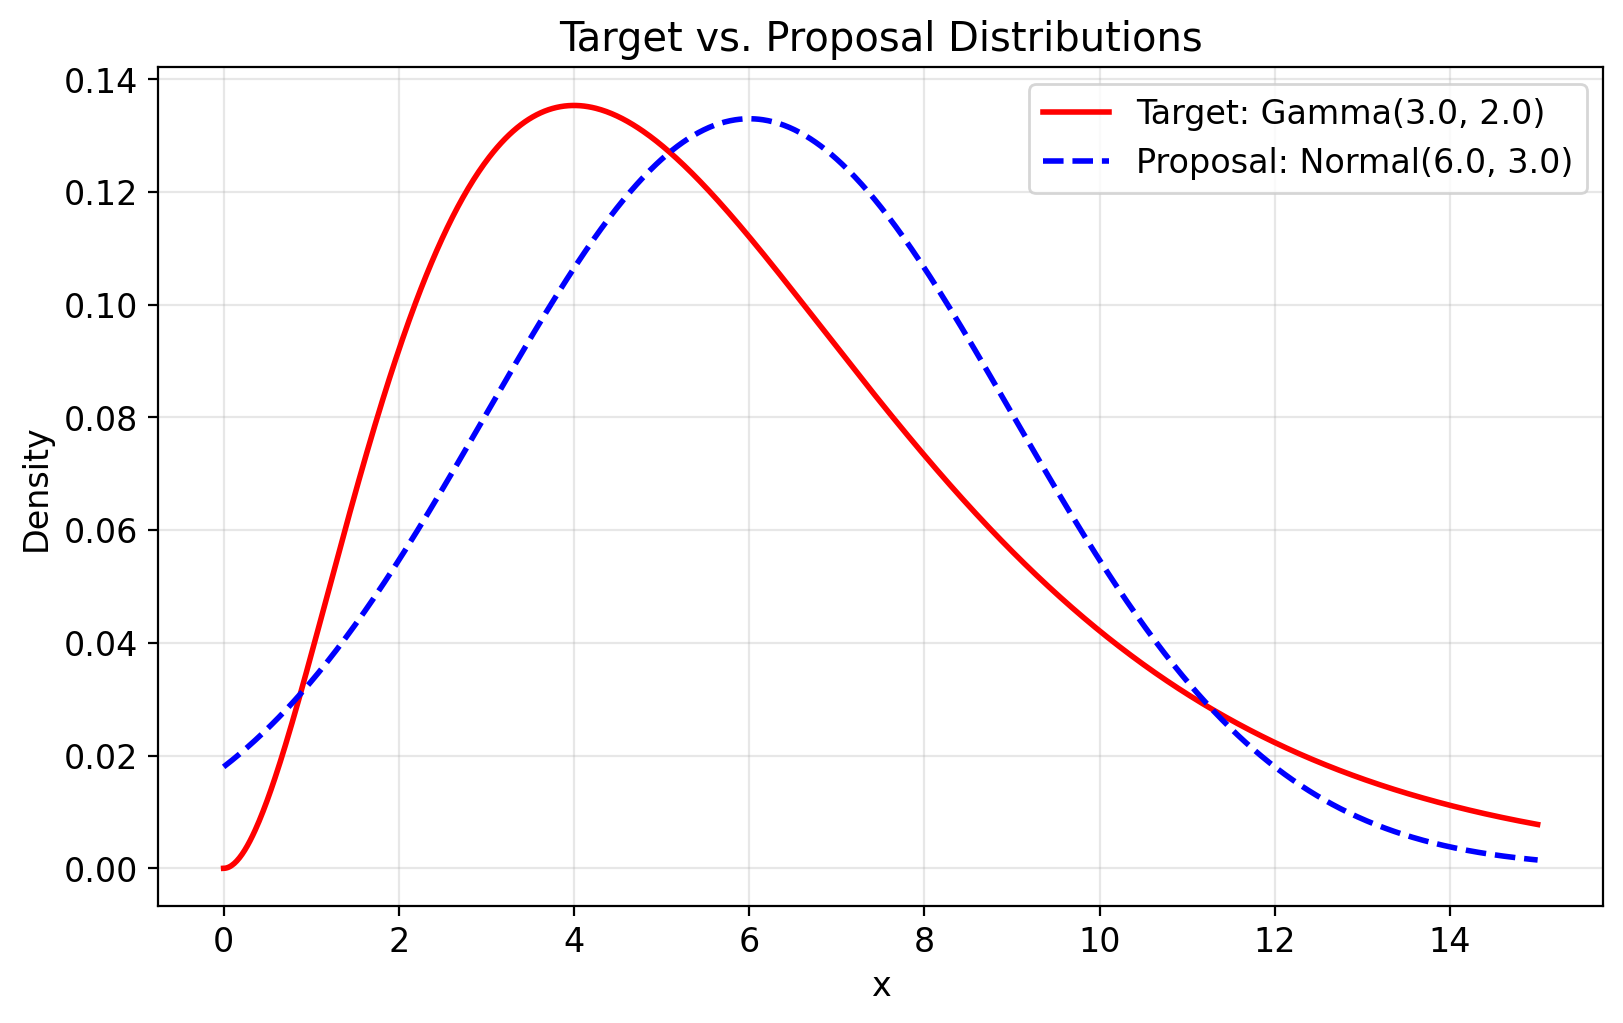

In [5]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

plt.rcParams.update(
    {
        "figure.constrained_layout.use": True,
        "figure.figsize": (10, 6),
        "font.size": 12,
    }
)

%config InlineBackend.figure_format = 'retina'

np.random.seed(SEED:=42)

x = np.linspace(0, 15, 1000)
gamma_pdf = stats.gamma.pdf(x, shape_true, scale=scale_true)
normal_pdf = stats.norm.pdf(x, mu_proposal, sigma_proposal)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x, gamma_pdf, 'r-', lw=2, label=f'Target: Gamma({shape_true}, {scale_true})')
ax.plot(x, normal_pdf, 'b--', lw=2, label=f'Proposal: Normal({mu_proposal}, {sigma_proposal})')
ax.set_xlabel('x')
ax.set_ylabel('Density')
ax.set_title('Target vs. Proposal Distributions')
ax.legend()
ax.grid(True, alpha=0.3)

First we generate candidate samples from the normal distribution:

In [6]:
M = 10000
samples = np.random.normal(mu_proposal, sigma_proposal, M)

Calculate importance weights:

`weights = target_pdf(samples) / proposal_pdf(samples)`

which are normalized to sum to 1.

In [7]:
target_pdf = stats.gamma.pdf(samples, shape_true, scale=scale_true)
proposal_pdf = stats.norm.pdf(samples, mu_proposal, sigma_proposal)
weights = target_pdf / proposal_pdf

# Remove invalid weights (from sampling in regions where target is defined but proposal isn't)
valid_idx = (weights > 0) & np.isfinite(weights)
samples = samples[valid_idx]
weights = weights[valid_idx]

# Normalize weights to sum to 1
normalized_weights = weights / np.sum(weights)

These weights are then used to magically convert the normal samples into gamma samples:

In [8]:
# Calculate importance sampling estimate of the mean
is_mean = np.sum(samples * normalized_weights)

# Calculate standard error of the estimate
is_se = np.sqrt(np.sum(((samples - is_mean) * normalized_weights)**2))

# Calculate effective sample size
ess = 1 / np.sum(normalized_weights**2)

print(f"Importance Sampling Estimate: {is_mean:.4f}")
print(f"Standard Error: {is_se:.4f}")
print(f"True Mean: {target_mean}")
print(f"Effective Sample Size: {ess:.1f} (out of {len(samples)} samples)")

Importance Sampling Estimate: 5.9698
Standard Error: 0.0844
True Mean: 6.0
Effective Sample Size: 6386.0 (out of 9770 samples)


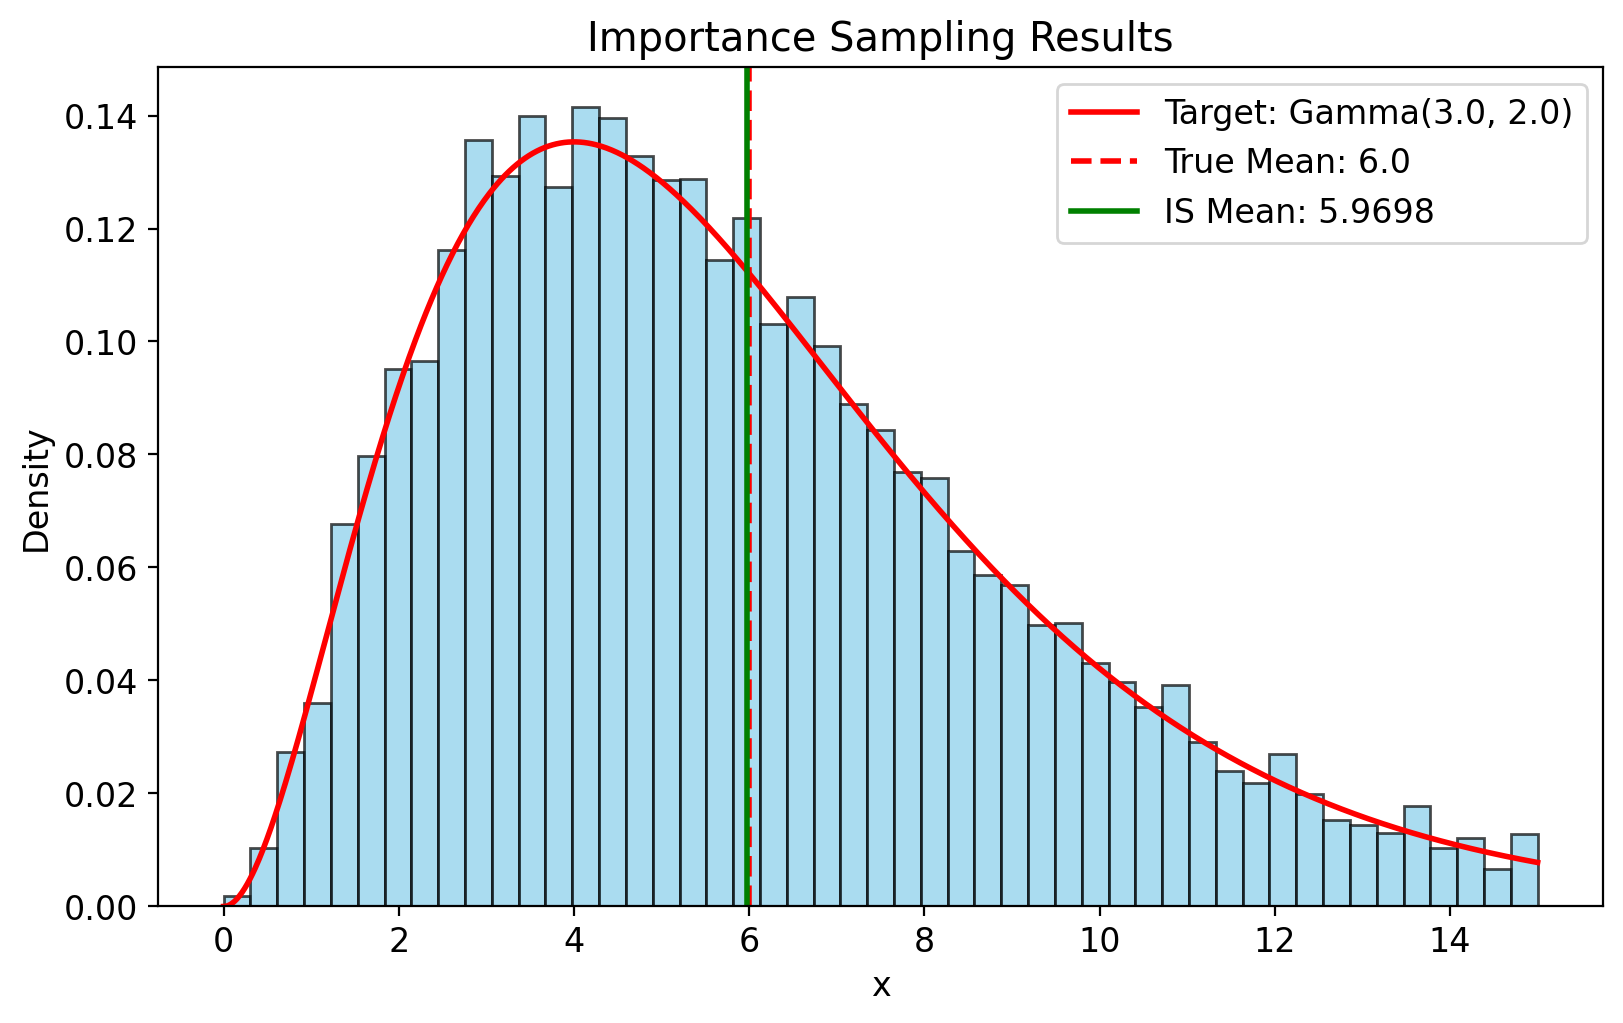

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))

bins = np.linspace(0, 15, 50)
hist_weights = normalized_weights * len(normalized_weights)  
ax.hist(samples, bins=bins, weights=hist_weights, alpha=0.7, 
         color='skyblue', edgecolor='black', density=True)

ax.plot(x, gamma_pdf, 'r-', lw=2, label=f'Target: Gamma({shape_true}, {scale_true})')

ax.axvline(target_mean, color='r', linestyle='--', lw=2, label=f'True Mean: {target_mean}')
ax.axvline(is_mean, color='g', linestyle='-', lw=2, label=f'IS Mean: {is_mean:.4f}')
ax.set_title('Importance Sampling Results')
ax.set_xlabel('x')
ax.set_ylabel('Density')
ax.legend()

### Multi-path Enhancement

The basic Pathfinder algorithm described above is called "Single-path Pathfinder." To improve the quality of approximation, especially for complex posteriors, we can run multiple independent paths and combine their results.

This **Multi-path Pathfinder** approach:

1. Runs multiple independent Pathfinder instances from different starting points
2. Generates $M$ draws from its ELBO-maximizing normal approximation
3. Uses importance sampling to combine all draws from all paths
4. Selects the final $R$ samples based on their importance weights

This is particularly useful for complex posteriors that may have multiple modes or non-normal shapes. By combining samples from different paths, we can better capture the true posterior distribution.

## Using Pathfinder in PyMC

Let's see how to use Pathfinder for practical Bayesian modeling in PyMC. We'll need to import the necessary libraries:

In [11]:
import pandas as pd
import pymc as pm
import pymc_extras as pmx
import pytensor.tensor as pt
import arviz as az
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
az.style.use("arviz-darkgrid")

## Example 1: The Eight Schools Problem

The Eight Schools problem is a classic example in Bayesian statistics, originally analyzed by Rubin (1981). It involves estimating the effects of coaching programs on SAT scores across eight schools.

This is a good starting example because:
1. It's small enough to understand easily
2. It has a hierarchical structure that creates some posterior complexity
3. It's commonly used as a benchmark in Bayesian methods

In [12]:
J = 8  # number of schools
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])  # observed effects
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])  # standard errors

Now let's build a hierarchical model for this problem:

In [13]:
with pm.Model(coords={"school": np.arange(J)}) as model:

    baseline = pm.Normal("baseline", mu=0.0, sigma=10.0)  # overall effect
    school_sd = pm.Gamma("school_sd", 2, 2)  # between-school variability
    
    school_offset = pm.ZeroSumNormal("school_offset", dims="school")
    
    _ = pm.Normal(
        "obs",
        mu=baseline + school_sd * school_offset,
        sigma=sigma,
        observed=y,
        dims="school",
    )

A few notes about this model:

1. We've used `ZeroSumNormal` for the school offsets, which constrains them to sum to zero. This is a better parametrization than the traditional one that can lead to sampling difficulties.

2. We're using a `Gamma(2, 2)` prior for `school_sd` instead of a `HalfCauchy(5)`. The Gamma has less density at very high values, reflecting that schools typically aren't extremely different from each other.

Now let's fit this model using different methods for comparison:

In [ ]:
with model:
    idata_nuts = pm.sample(random_seed=SEED)
    idata_advi = pm.fit(n=30_000).sample(1000, random_seed=SEED)
    idata_pf = pmx.fit(method="pathfinder", random_seed=SEED)

NameError: name 'seed' is not defined

Let's create a helper function to visualize and compare our results:

In [29]:
def compare_methods(results, var_names=None):
    """Plot posterior distributions from different inference methods"""
    az.plot_forest(
        [results[key] for key in results.keys()],
        model_names=list(results.keys()),
        var_names=var_names,
        combined=True,
        figsize=(10, 10),
        kind="ridgeplot",
        ridgeplot_alpha=0.5,
    )
    plt.tight_layout()

/tmp/ipykernel_40703/2771540804.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


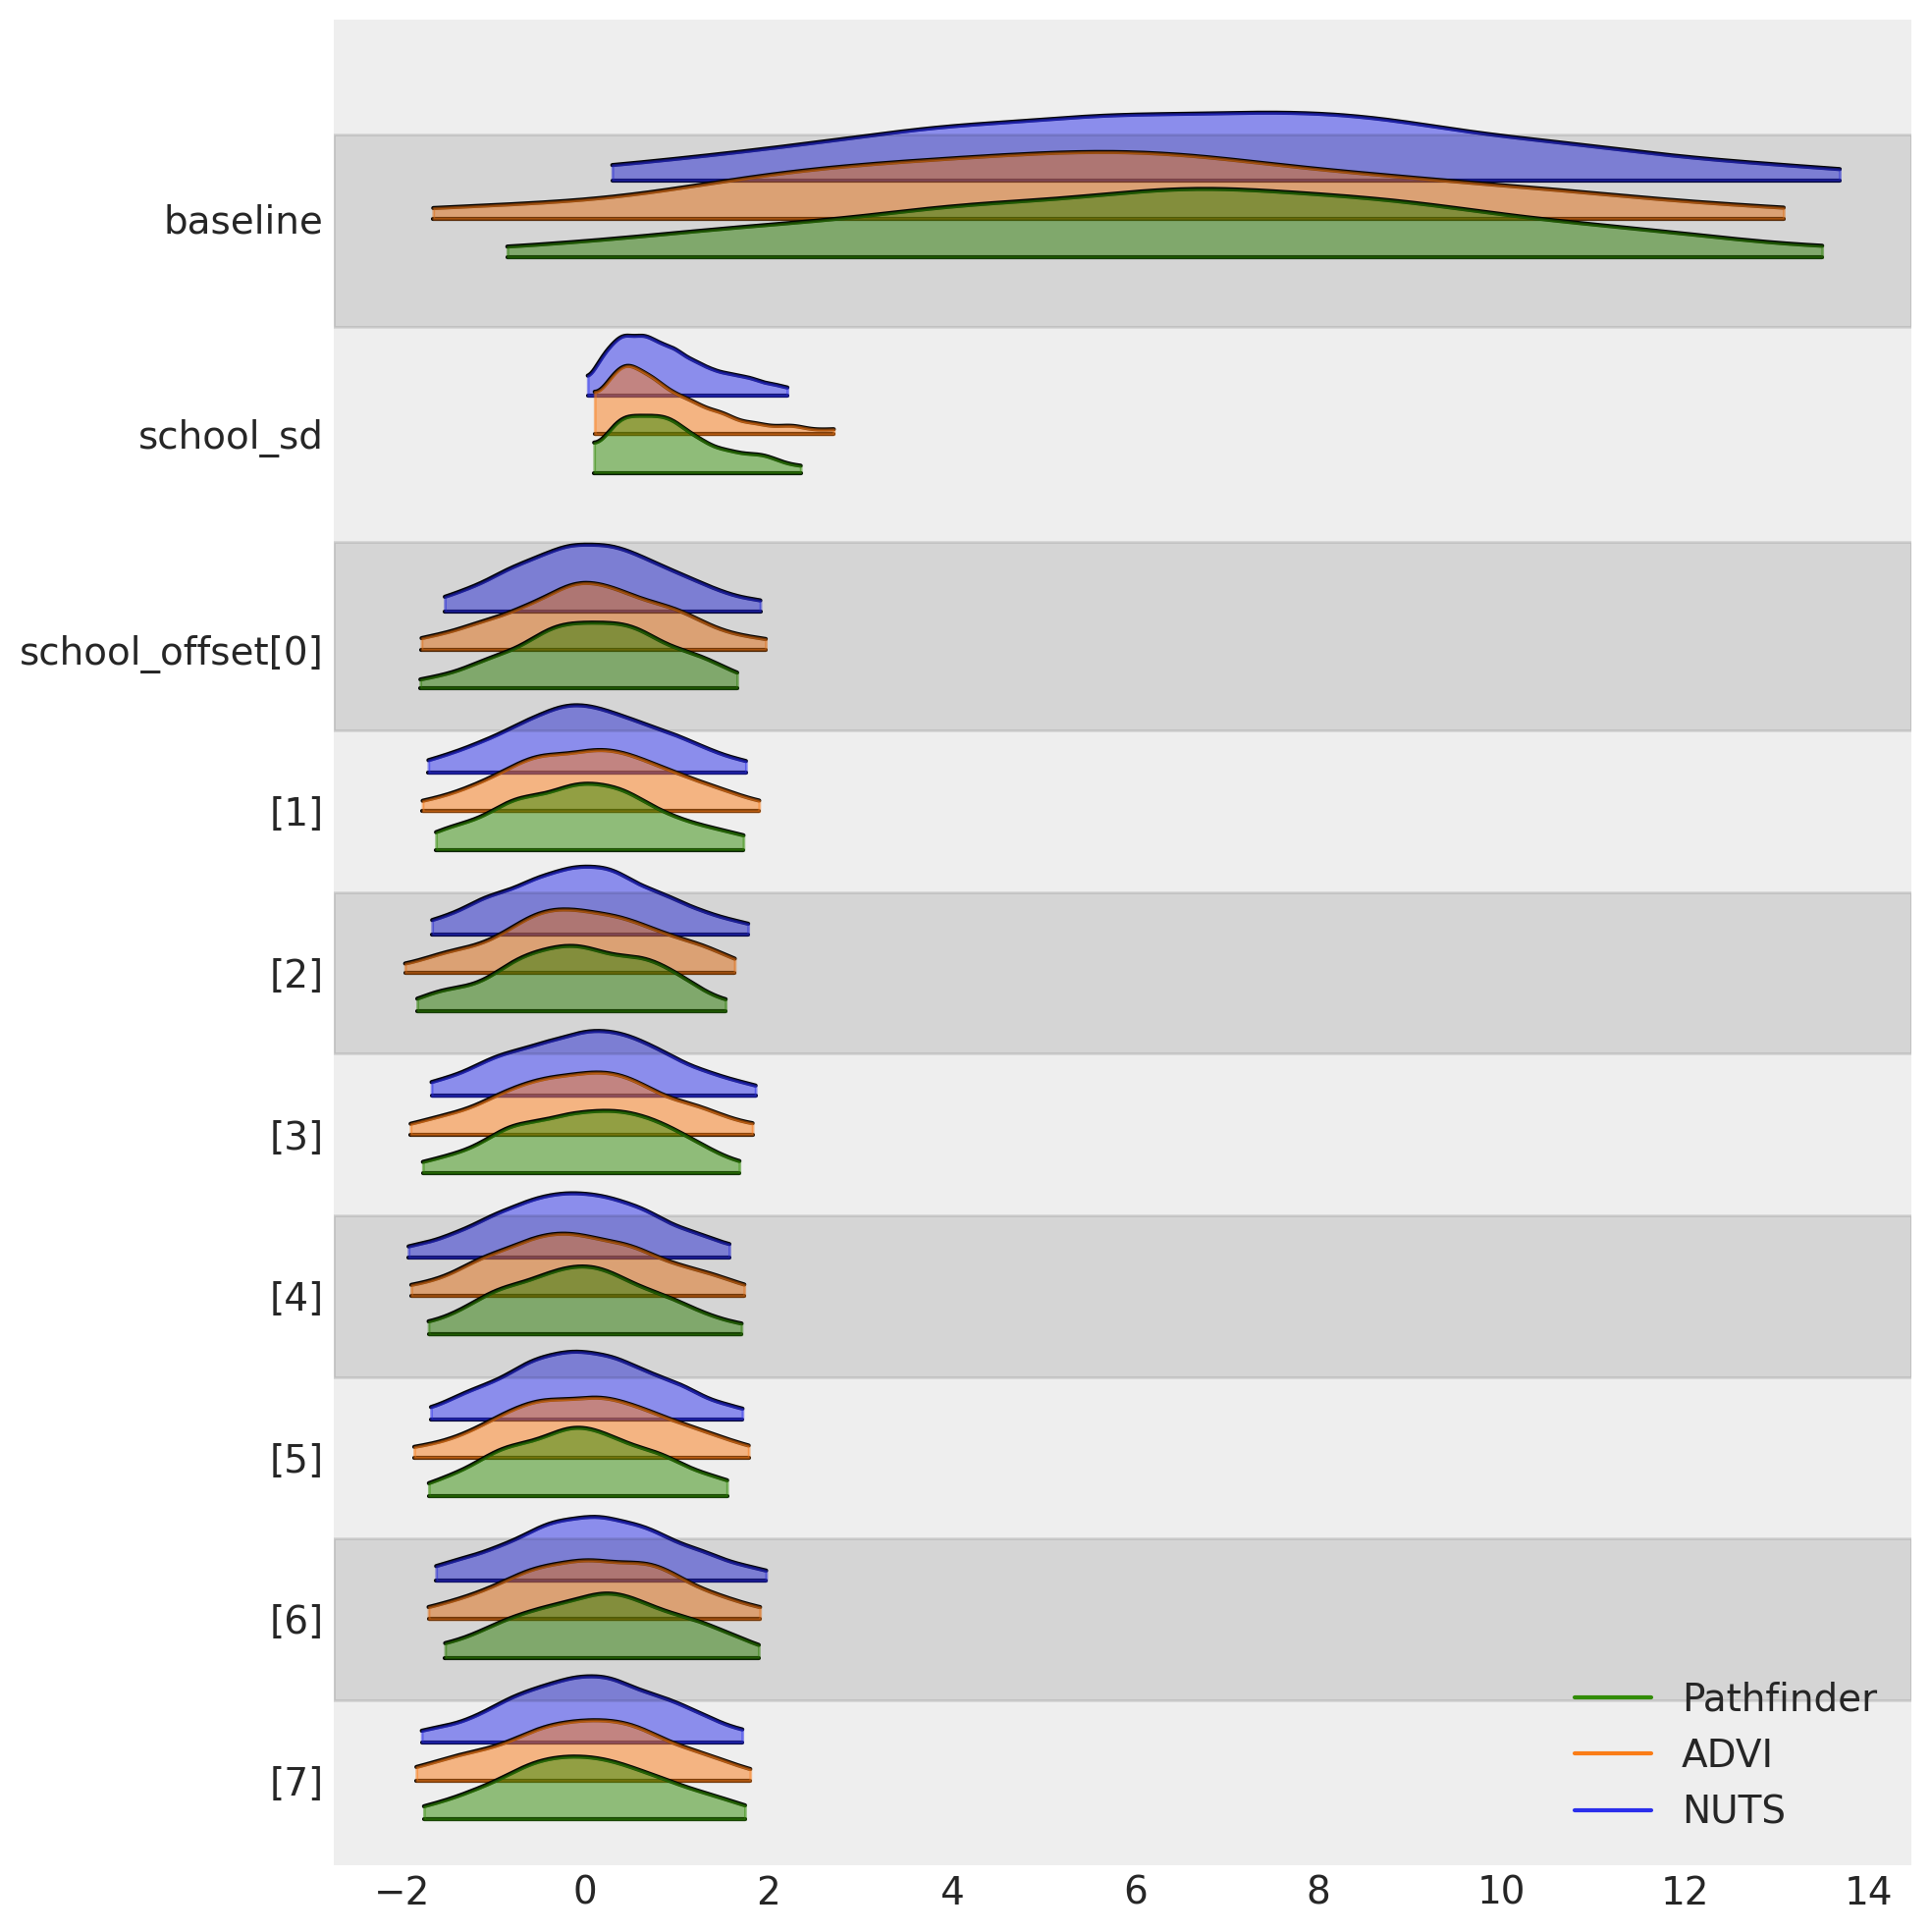

In [30]:
var_names = [RV.name for RV in model.free_RVs]
res = {"NUTS": idata_nuts, "ADVI": idata_advi, "Pathfinder": idata_pf}

compare_methods(res, var_names=var_names)

### Improving Pathfinder Results

Pathfinder has several tuning parameters we can adjust to improve its performance:

1. **jitter**: Controls how far the starting points are from the initial position
2. **num_paths**: Number of independent Pathfinder runs for Multi-path Pathfinder
3. **maxcor**: History size for L-BFGS optimization

Let's try using Multi-path Pathfinder with more exploratory settings:

In [ ]:
with model:

    idata_pf_tuned = pmx.fit(
        method="pathfinder",
        num_paths=10,  
        jitter=5.0, 
        random_seed=SEED
    )

/var/home/fonnesbeck/repos/vi_pydata_virginia_2025/.pixi/envs/default/lib/python3.12/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/var/home/fonnesbeck/repos/vi_pydata_virginia_2025/.pixi/envs/default/lib/python3.12/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/var/home/fonnesbeck/repos/vi_pydata_virginia_2025/.pixi/envs/default/lib/python3.12/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/var/home/fonnesbeck/repos/vi_pydata_virginia_2025/.pixi/envs/default/lib/python3.12/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjut

Output()

Pathfinder Results                          
                                            
  No. model parameters     9                
                                            
  Configuration:                            
  num_draws_per_path       1000             
  history size (maxcor)    7                
  max iterations           1000             
  ftol                     1.00e-05         
  gtol                     1.00e-08         
  max line search          1000             
  jitter                   5.0              
  epsilon                  1.00e-08         
  ELBO draws               10               
                                            
  LBFGS Status:                             
  CONVERGED                10               
  L-BFGS iterations        mean 14 ± std 4  
                                            
  Path Status:                              
  SUCCESS                  10               
  ELBO argmax              mean 10 ± std 4  
                                            
  Importance Sampling:                      
  Method                   psis             
  Pareto k                 0.63             
                                            
  Timing (seconds):                         
  Compile                  4.17             
  Compute                  0.16             
  Total                    4.34

/tmp/ipykernel_40703/2771540804.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


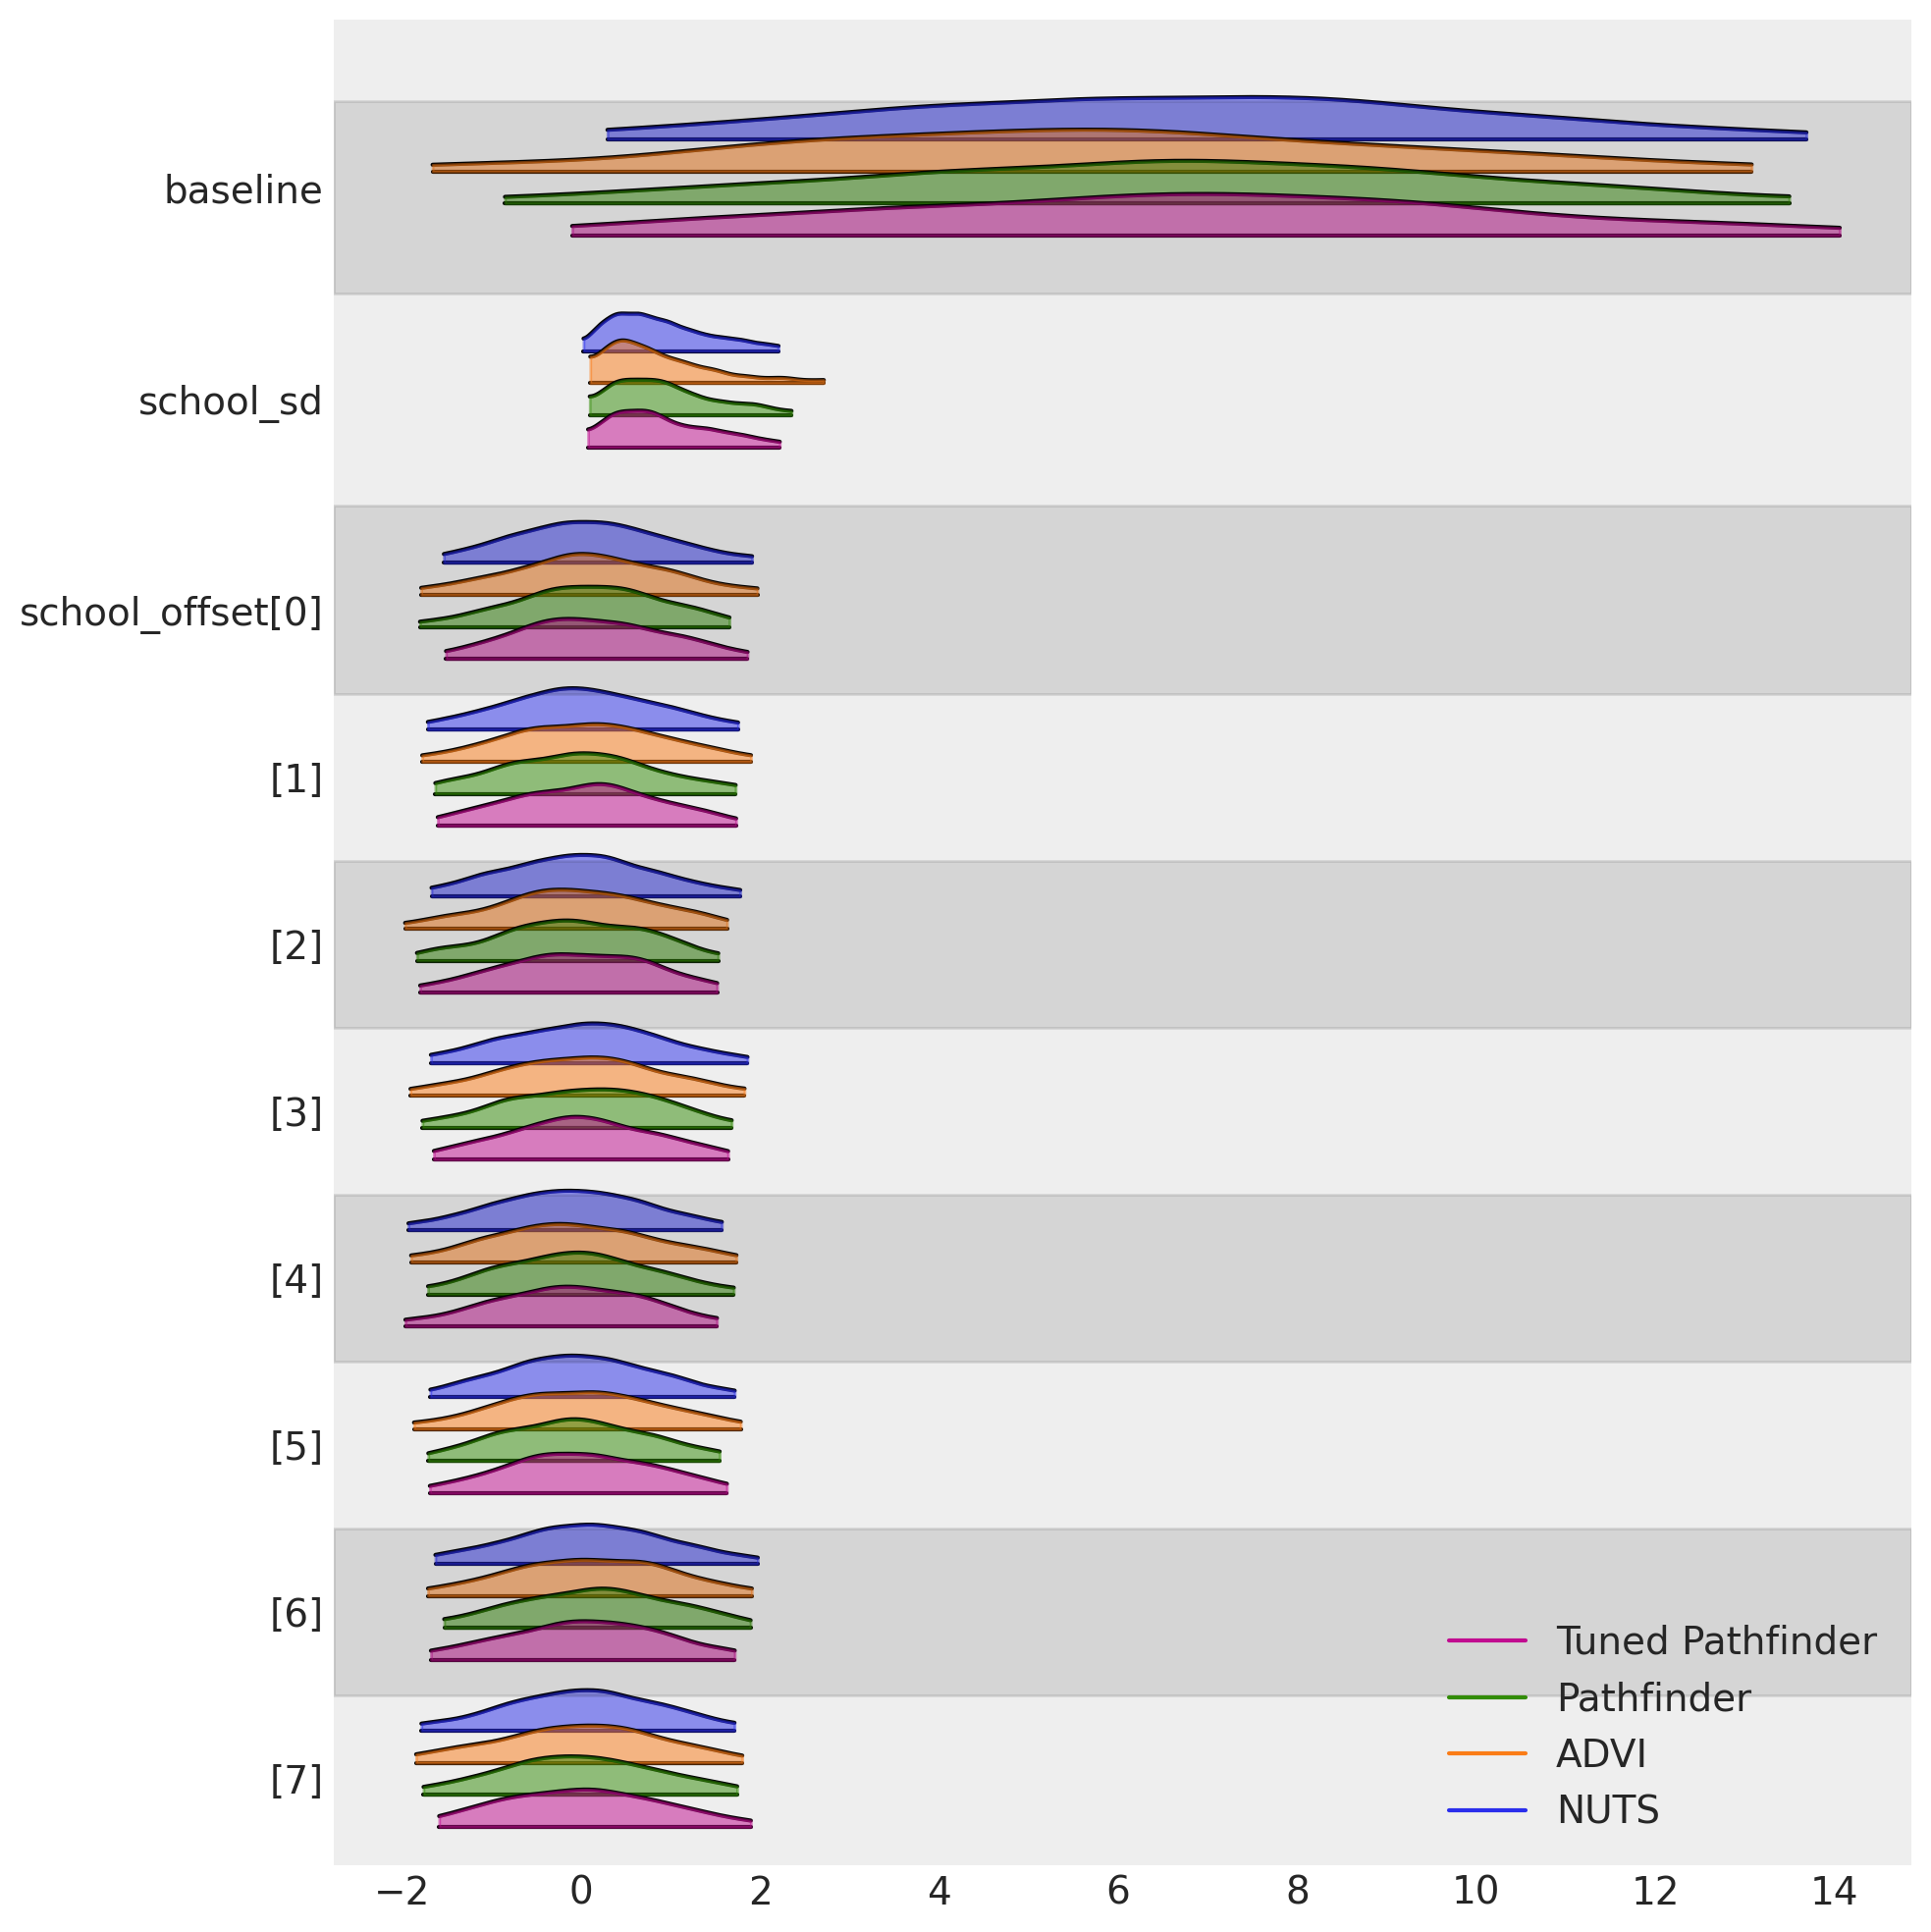

In [32]:
res["Tuned Pathfinder"] = idata_pf_tuned
compare_methods(res, var_names=var_names)

## Example 2: Modeling Rugby Match Scores

Now let's try Pathfinder on a more complex model. We'll look at a Poisson regression model for rugby match scores, which helps us estimate team attack and defense strengths.

In [33]:
try:
    df_all = pd.read_csv("../data/rugby.csv", index_col=0)
except Exception:
    df_all = pd.read_csv(pm.get_data("rugby.csv"), index_col=0)

df_all.head()

,home_team,away_team,home_score,away_score,year
0,Wales,Italy,23,15,2014
1,France,England,26,24,2014
2,Ireland,Scotland,28,6,2014
3,Ireland,Wales,26,3,2014
4,Scotland,England,0,20,2014


In [34]:
home_idx, teams = pd.factorize(df_all["home_team"], sort=True)
away_idx, _ = pd.factorize(df_all["away_team"], sort=True)
coords = {"match": df_all.index, "team": teams}

In [35]:
with pm.Model(coords=coords) as rugby_model:

    home_team = pm.Data("home_team", home_idx, dims="match")
    away_team = pm.Data("away_team", away_idx, dims="match")

    home = pm.Normal("home", mu=0, sigma=1)        # home advantage
    sd_att = pm.HalfNormal("sd_att", sigma=2)      # variability in attack
    sd_def = pm.HalfNormal("sd_def", sigma=2)      # variability in defense
    intercept = pm.Normal("intercept", mu=3, sigma=1)  # baseline scoring rate

    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, dims="team")
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, dims="team")

    atts = pm.Deterministic("atts", atts_star - pt.mean(atts_star), dims="team")
    defs = pm.Deterministic("defs", defs_star - pt.mean(defs_star), dims="team")
    
    home_theta = pt.exp(intercept + home + atts[home_idx] + defs[away_idx])
    away_theta = pt.exp(intercept + atts[away_idx] + defs[home_idx])

    home_points = pm.Poisson(
        "home_points",
        mu=home_theta,
        observed=df_all["home_score"],
        dims="match",
    )
    away_points = pm.Poisson(
        "away_points",
        mu=away_theta,
        observed=df_all["away_score"],
        dims="match",
    )

This model has more parameters than the Eight Schools example, making it a better test for scalability. Let's fit it using different methods:

In [ ]:
with rugby_model:
    idata_nuts = pm.sample(random_seed=SEED)
    idata_advi = pm.fit(n=30_000).sample(1000, random_seed=SEED)
    idata_pf = pmx.fit(
        method="pathfinder", 
        num_paths=15, 
        jitter=10.0, 
        random_seed=SEED
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, sd_att, sd_def, intercept, atts_star, defs_star]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Finished [100%]: Average Loss = 557.56
/var/home/fonnesbeck/repos/vi_pydata_virginia_2025/.pixi/envs/default/lib/python3.12/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/var/home/fonnesbeck/repos/vi_pydata_virginia_2025/.pixi/envs/default/lib/python3.12/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/var/home/fonnesbeck/repos/vi_pydata_virginia_2025/.pixi/envs/default/lib/python3.12/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched_dot is deprecated. Use `dot` in conjution with `tensor.vectorize` or `graph.replace.vectorize_graph`
  warnings.warn(
/var/home/fonnesbeck/repos/vi_pydata_virginia_2025/.pixi/envs/default/lib/python3.12/site-packages/pytensor/tensor/blas.py:1736: FutureWarning: batched

Output()

Pathfinder Results                           
                                             
  No. model parameters     16                
                                             
  Configuration:                             
  num_draws_per_path       1000              
  history size (maxcor)    9                 
  max iterations           1000              
  ftol                     1.00e-05          
  gtol                     1.00e-08          
  max line search          1000              
  jitter                   10.0              
  epsilon                  1.00e-08          
  ELBO draws               10                
                                             
  LBFGS Status:                              
  CONVERGED                15                
  L-BFGS iterations        mean 74 ± std 15  
                                             
  Path Status:                               
  SUCCESS                  15                
  ELBO argmax              mean 64 ± std 17  
                                             
  Importance Sampling:                       
  Method                   psis              
  Pareto k                 1.03              
                                             
  Timing (seconds):                          
  Compile                  7.88              
  Compute                  0.87              
  Total                    8.75

/tmp/ipykernel_40703/2771540804.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


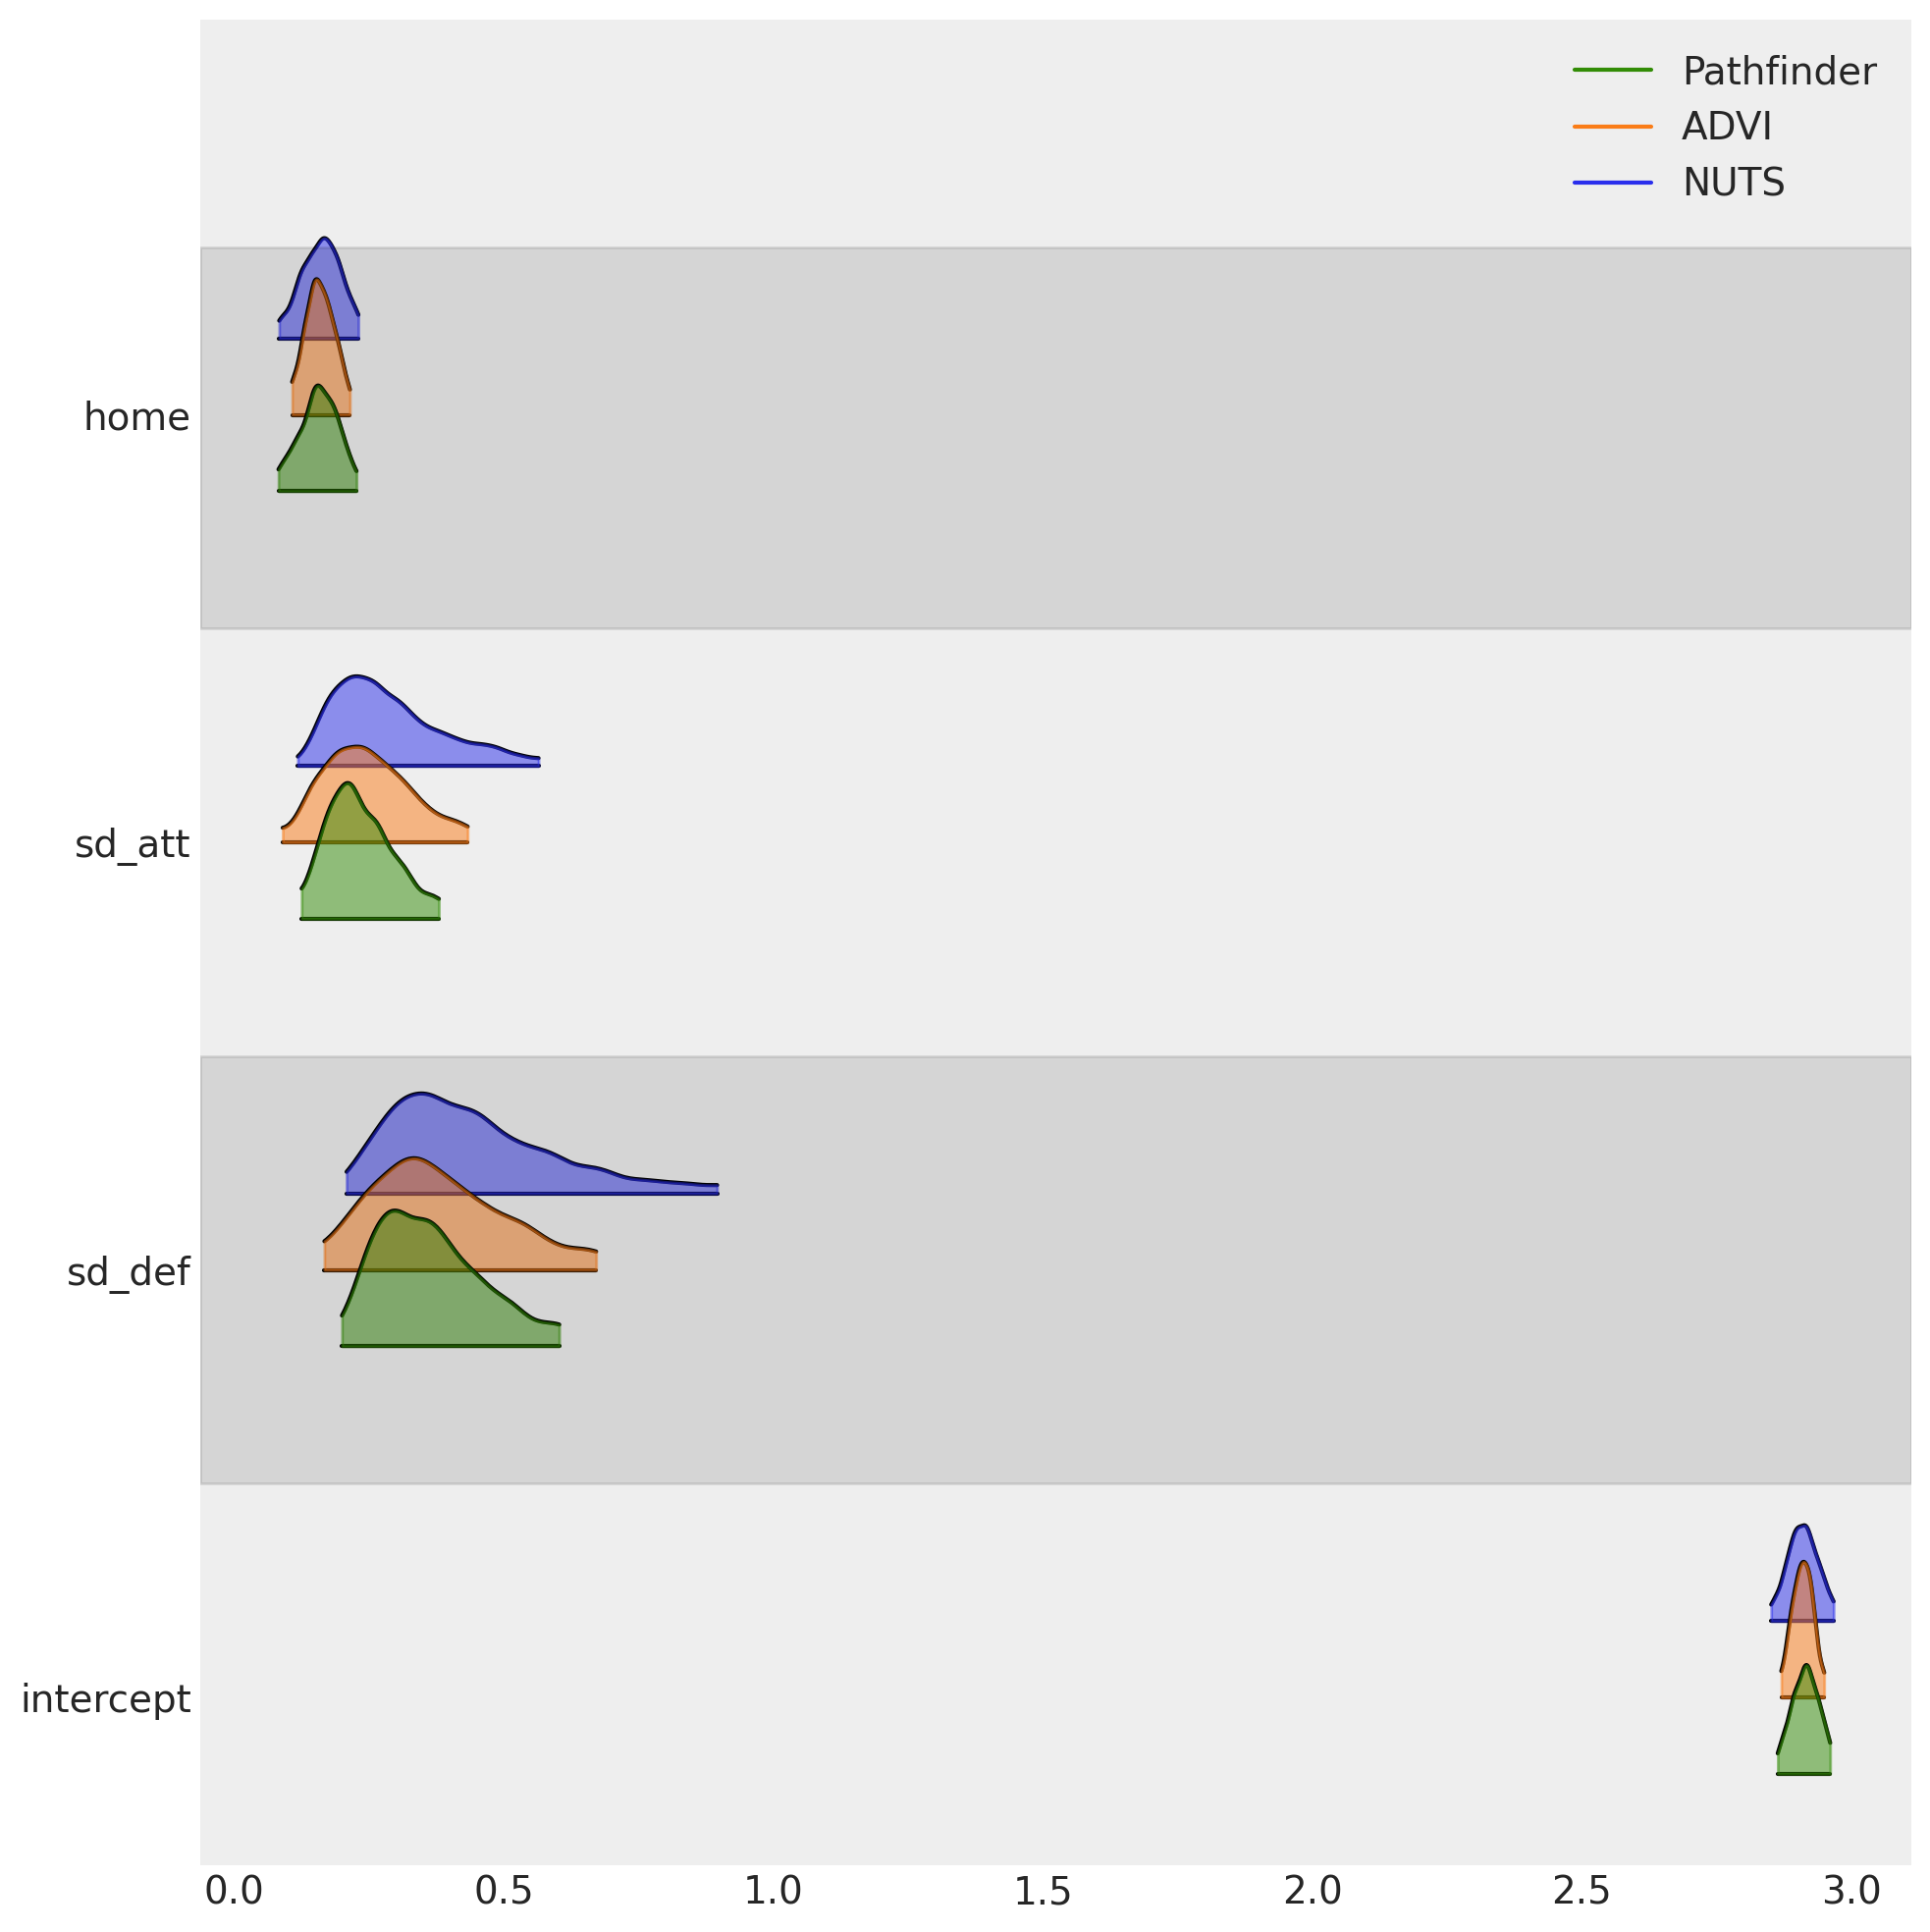

In [37]:
var_names = ["home", "sd_att", "sd_def", "intercept"]
res = {"NUTS": idata_nuts, "ADVI": idata_advi, "Pathfinder": idata_pf}

compare_methods(res, var_names=var_names)

Let's also look at team-specific parameters to see how well Pathfinder captures these:

/tmp/ipykernel_40703/2771540804.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


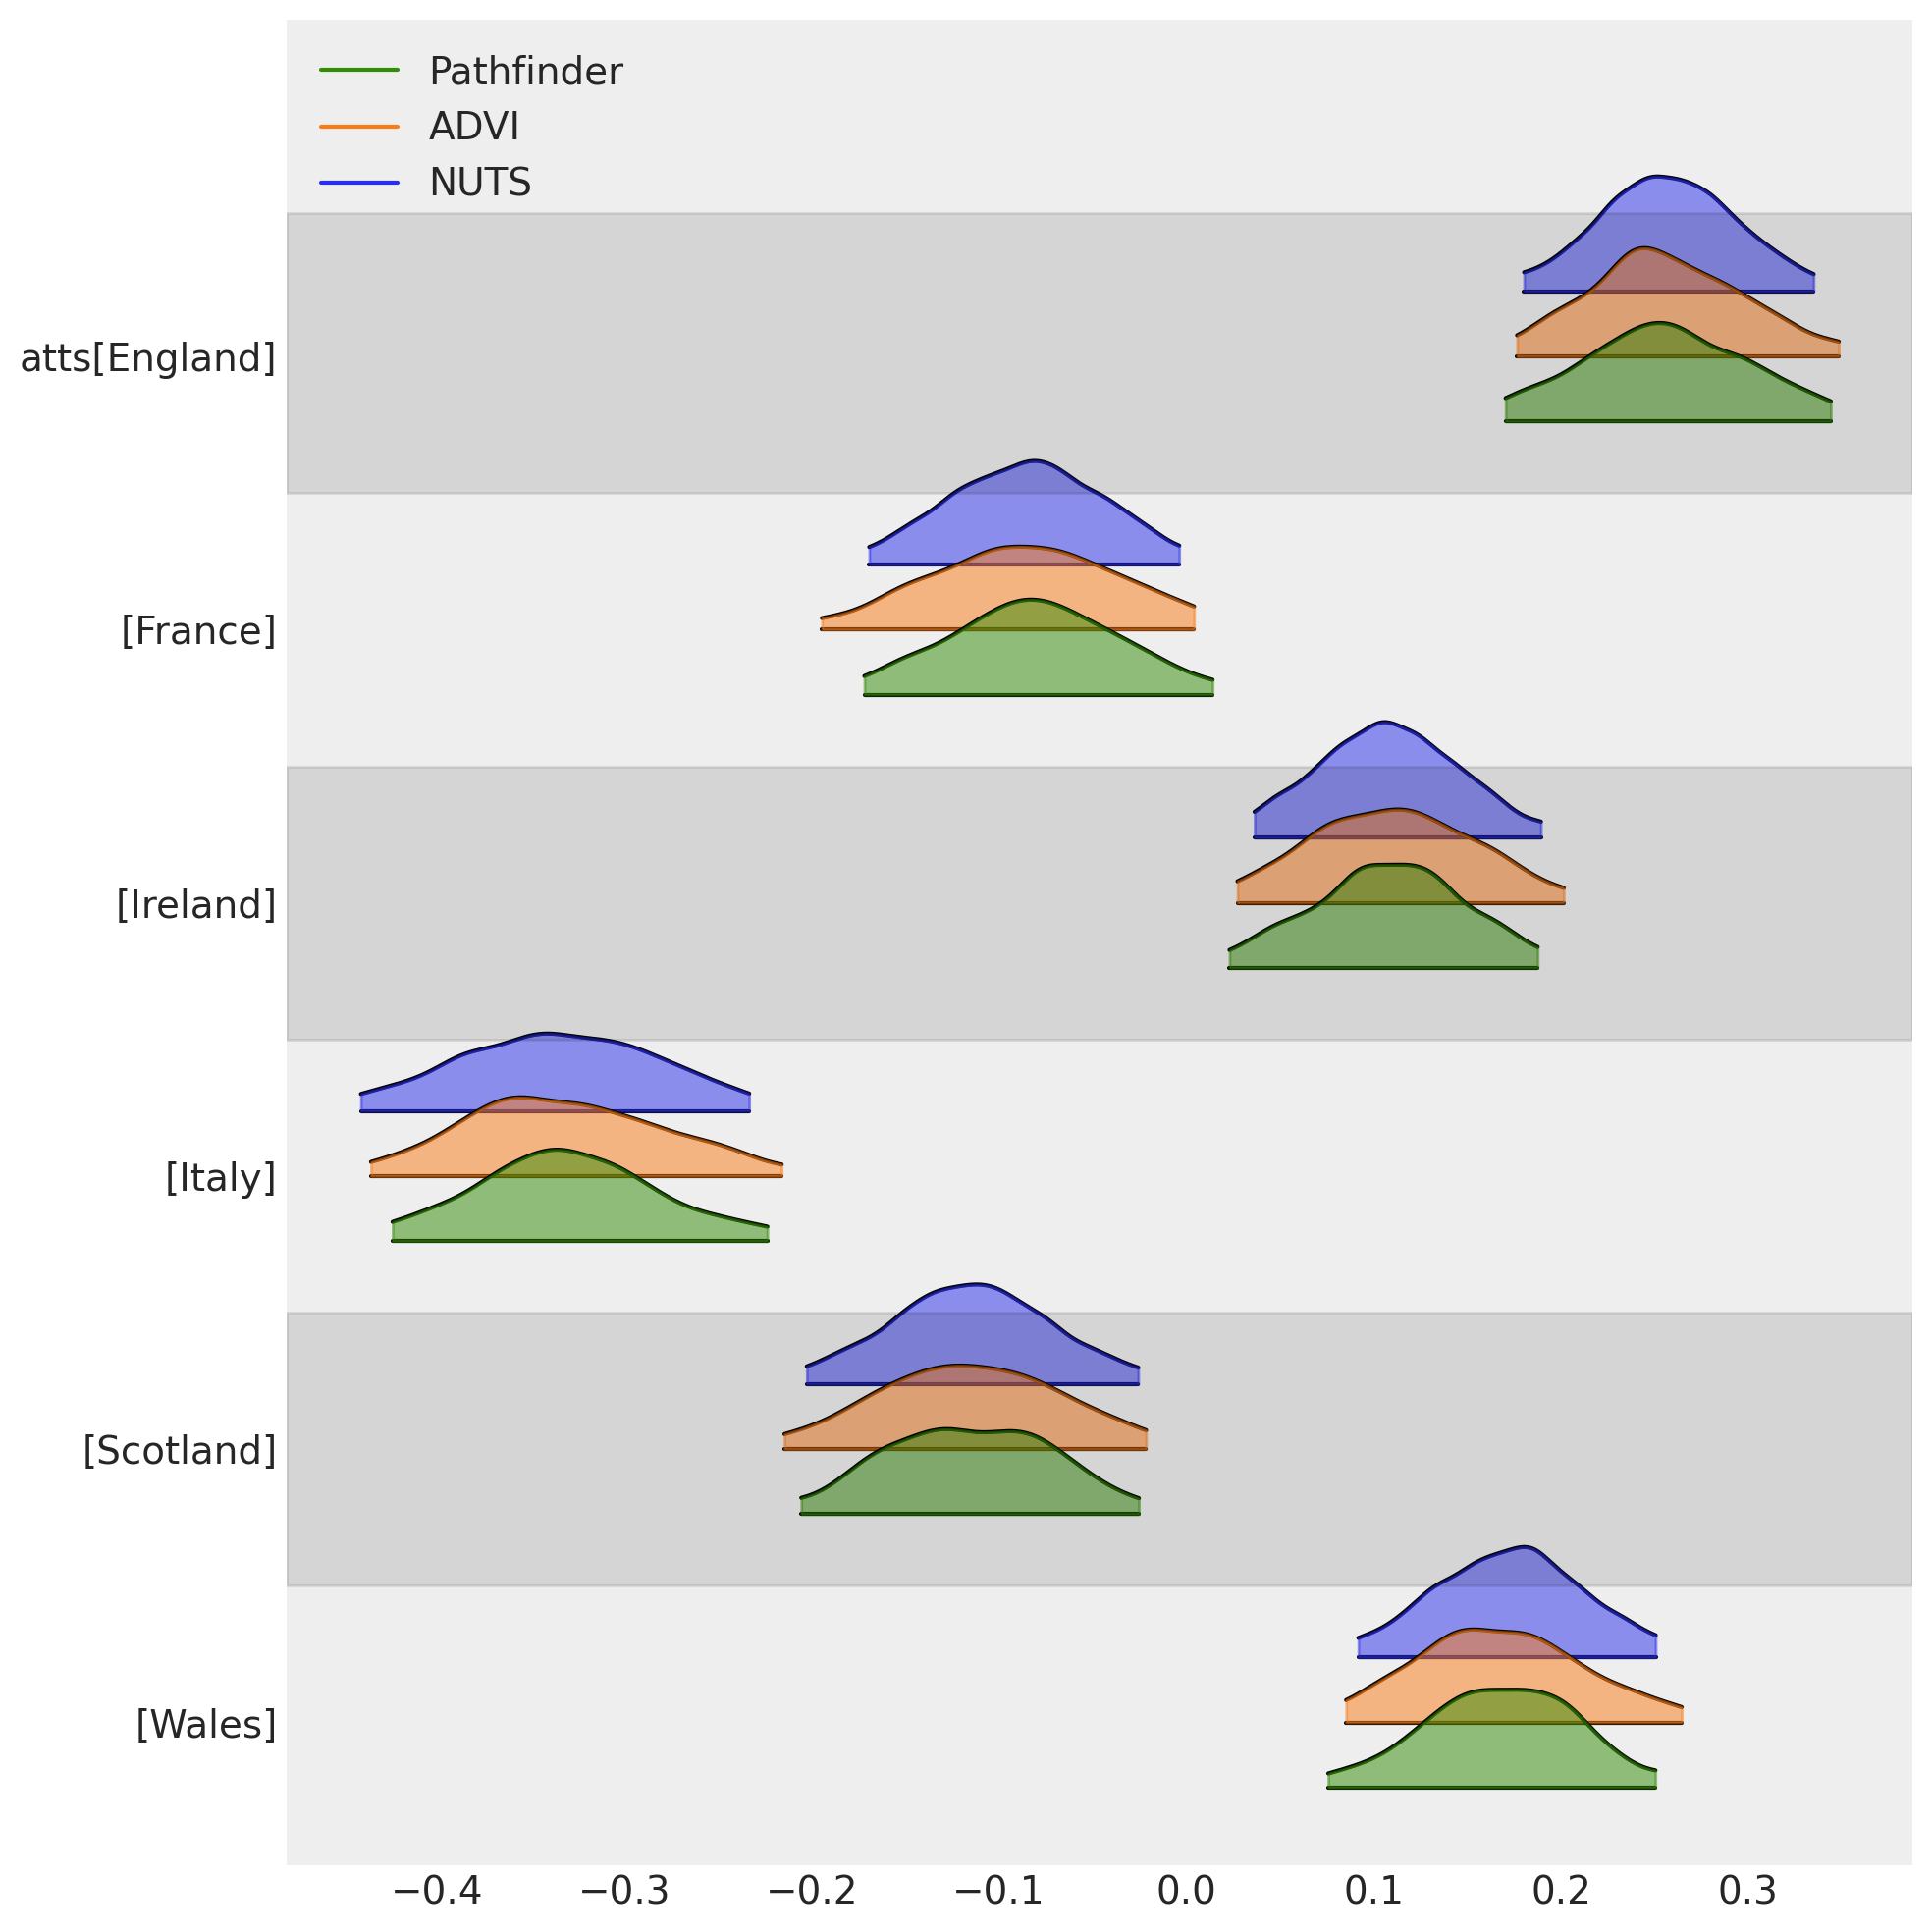

In [38]:
compare_methods(res, var_names=["atts"])

## When to Use Pathfinder

Based on our examples, here are some guidelines for when Pathfinder might be the right choice:

### Advantages of Pathfinder:

1. **Speed**: Pathfinder is typically much faster than MCMC methods, especially for large models.
2. **Scalability**: Works well with high-dimensional problems where MCMC might struggle.
3. **Initialization**: Can be used to initialize MCMC for faster convergence.
4. **Reasonable approximations**: For many models, the approximation quality is good enough for practical use.

### When to be cautious:

1. **Complex posteriors**: Multi-modal or highly skewed distributions may not be captured well by a small number of normal approximations.
2. **High precision requirements**: When you need the most accurate posterior possible and compute time isn't a concern, MCMC might still be preferable.
3. **Model diagnostics**: For new or complex models, it's a good idea to compare Pathfinder results with MCMC to ensure good approximation.

## Tuning Pathfinder

If you're using Pathfinder and want to improve its performance, here are some parameters to consider tuning:

1. **num_paths**: Increasing this runs multiple independent paths and can help capture more complex posteriors. Try values from 4 (default) to 50 or more for complex problems.

2. **jitter**: Controls how far initial points are from each other. Higher values explore more of the parameter space. Default is 2.0, but try 5.0-20.0 for complex models.

3. **maxcor**: The history size for L-BFGS optimization. Larger values can help with complex curvature. Default is min(model dimension, 10), but you can try higher values for complex models.

4. **num_draws_per_path**: Number of samples drawn from each approximation. Default is 1000, but you might increase for more stable results.

5. **importance_sampling**: Method used for combining results across paths. Options are "psis" (default) or "psir". PSIS generally works better in practice.

## Conclusion

Pathfinder offers a compelling approach to variational inference that can significantly speed up Bayesian modeling workflows. It works by finding an optimization path through parameter space, creating normal approximations along the way, and selecting the best one using the ELBO.

Key takeaways:

1. Pathfinder is generally much faster than MCMC methods like NUTS.
2. The quality of approximation is often good enough for many practical applications.
3. Multi-path Pathfinder with tuned settings can substantially improve results.
4. For critical applications, it's good practice to verify Pathfinder results with MCMC.

This makes Pathfinder a valuable addition to your Bayesian modeling toolkit, especially when you need quick results for exploratory analysis or with large models where MCMC might be prohibitively slow.

---
## References

1. Zhang, Lu, et al. "Pathfinder: Parallel quasi-Newton variational inference." arXiv preprint arXiv:2108.03782 (2021).
2. Rubin, Donald B. "Estimation in parallel randomized experiments." Journal of Educational Statistics 6.4 (1981): 377-401.

In [39]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Apr 16 2025

Python implementation: CPython
Python version       : 3.12.10
IPython version      : 9.1.0

pymc_extras: 0.2.4
pymc       : 5.22.0
pytensor   : 2.30.3
pandas     : 2.2.3
matplotlib : 3.10.1
scipy      : 1.12.0
numpy      : 1.26.4
arviz      : 0.21.0

Watermark: 2.5.0

